In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees

# Arguments 

In [2]:
corr = 0.25
seq_length = 800

# Load Model

In [3]:
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze")

epoch=35-val_loss=0.000347.ckpt


In [28]:
eval_dset_path

'/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr0.25_state_dim10_envs1000_H1600_explore/datasets/eval.pkl'

In [4]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [5]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')


# Load Dataset and Create Environment

In [8]:
def load_eval_trajs(eval_dset_path):
    is_h5_file = eval_dset_path.endswith('.h5')
    if is_h5_file:
        eval_trajs = h5py.File(eval_dset_path, 'r')
    else:  # Pickle file
        with open(eval_dset_path, 'rb') as f:
            eval_trajs = pickle.load(f)
    n_eval_envs = len(eval_trajs)
    return eval_trajs, n_eval_envs

eval_trajs_1, n_eval_envs_1 = load_eval_trajs(eval_dset_path)
eval_trajs_2, n_eval_envs_2 = load_eval_trajs(eval_dset_path.replace('eval', 'train'))
eval_trajs_3, n_eval_envs_3 = load_eval_trajs(eval_dset_path.replace('eval', 'test'))
eval_trajs = eval_trajs_1 + eval_trajs_2 + eval_trajs_3
n_eval_envs = n_eval_envs_1 + n_eval_envs_2 + n_eval_envs_3

In [9]:
def run_model(traj, model, seq_length=1200, start_idx=800):
    hidden_states = []

    batch = {
        'context_states': convert_to_tensor([np.array(traj['context_states'])]),
        'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
        'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
        'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
        'query_states': convert_to_tensor([np.array(traj['query_state'])]),  # Ignored
        }
    batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
    for k in batch.keys():
        if 'context' in k:
            batch[k] = batch[k][:,:seq_length]
        batch[k] = batch[k].to(model.device)
    model.save_activations = True
    with torch.no_grad():
        out = model(batch)
    _hidden_states = model.activations['hidden_states'] # Tuple over layers of (1, seq, dim)
    state_features = batch['context_states'][0][start_idx:].to('cpu').numpy()
    next_state_features = batch['context_next_states'][0][start_idx:].to('cpu').numpy()
    actions = batch['context_actions'][0].argmax(dim=1)[start_idx:].to('cpu').numpy()
    for i_layer in range(len(_hidden_states)):
        hidden_states.append(_hidden_states[i_layer][0,start_idx:-1])
    return hidden_states, state_features, next_state_features, actions

# Across context decoding

In [10]:
def get_subtree_location(layer, pos, subtree):
    midpt = 2**(layer-1)
    quarter_pt = midpt//2
    eighth_pt = quarter_pt//2
    if layer == 0:
        return 0
    if subtree == 'half':
        return 1 if pos < midpt else 2
    elif subtree == 'quarter':
        if layer == 1:
            return 0
        bins = np.arange(0, 2**layer, quarter_pt)
        return np.digitize([pos], bins)[0]
    elif subtree == 'eighth':
        if (layer == 1) or (layer == 2):
            return 0
        bins = np.arange(0, 2**layer, eighth_pt)
        return np.digitize([pos], bins)[0]

    

In [11]:
def make_train_test_matrices():
    train_envs = np.arange(1, int(n_eval_envs*0.9))
    test_envs = np.arange(int(n_eval_envs*0.9), n_eval_envs)

    X_train = [[] for _ in range(model.n_layer+1)]
    X_test = [[] for _ in range(model.n_layer+1)]
    Ys_dict = {
        "dist_from_goal": {"Y_train": [], "Y_test": []},
        "layer": {"Y_train": [], "Y_test": []},
        "node_identity": {"Y_train": [], "Y_test": []},
        "maze_half": {"Y_train": [], "Y_test": []},
        "maze_quarter": {"Y_train": [], "Y_test": []},
        "maze_eighth": {"Y_train": [], "Y_test": []},
        'is_goal': {"Y_train": [], "Y_test": []},
        'same_half_as_goal': {"Y_train": [], "Y_test": []},
        'same_quarter_as_goal': {"Y_train": [], "Y_test": []},
        'opt_action': {"Y_train": [], "Y_test": []},
        'state_feature': {"Y_train": [], "Y_test": []},
        'next_state_feature': {"Y_train": [], "Y_test": []},
        "on_path": {"Y_train": [], "Y_test": []},
        "on_lr_path": {"Y_train": [], "Y_test": []},
        "inverse_action": {"Y_train": [], "Y_test": []},
        "action": {"Y_train": [], "Y_test": []}
    }
    for i_eval in range(n_eval_envs):
        traj = eval_trajs[i_eval]
        first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
        if (first_reward.size == 0) or (first_reward[0] > seq_length):
            continue
        start_idx = first_reward[0].item()

        env_config = {
            'max_layers': 7,
            'horizon': 1600,
            'branching_prob': 1.0,
            'node_encoding_corr': corr,
            'state_dim': state_dim,
            'initialization_seed': np.array(traj['initialization_seed']).item()
        }
        env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
        opt_action_map, dist_from_goal = env.make_opt_action_dict()
        s = env.root.encoding()
        states_on_path_from_root_to_goal = [s]
        while True:
            action = np.zeros(4)
            action[opt_action_map[tuple(s)]] = 1
            s, _ = env.transit(np.array(s), action)
            states_on_path_from_root_to_goal.append(tuple(s))
            if np.array_equal(s, env.goal):
                break

        hidden_states, state_features, next_state_features, actions = run_model(traj, model, seq_length, start_idx)
        goal_node = env.node_map[tuple(env.goal.tolist())]
        goal_layer = goal_node.layer
        goal_pos = goal_node.pos
        seen_combos = set()
        for state_idx in reversed(range(len(state_features))):
            state_feature = state_features[state_idx]
            next_state_feature = next_state_features[state_idx]
            state_feature_tuple = tuple(state_feature.tolist())
            next_state_feature_tuple = tuple(next_state_feature.tolist())
            action = actions[state_idx]
            combo = tuple(state_feature.tolist() + next_state_feature.tolist())
            if combo in seen_combos:
                continue
            seen_combos.add(combo)
            d = dist_from_goal[next_state_feature_tuple]
            layer = env.node_map[next_state_feature_tuple].layer
            pos = env.node_map[next_state_feature_tuple].pos
            node_identity = 2**layer + pos
            maze_half = get_subtree_location(layer, pos, 'half')
            maze_quarter = get_subtree_location(layer, pos, 'quarter')
            maze_eighth = get_subtree_location(layer, pos, 'eighth')
            if action == 0:
                if env.node_map[next_state_feature_tuple].left == env.node_map[state_feature_tuple]:
                    inverse_action = 1
                elif env.node_map[next_state_feature_tuple].right == env.node_map[state_feature_tuple]:
                    inverse_action = 2
                else:
                    inverse_action = -1
            elif action == 1 or action == 2:
                inverse_action = 0
            else:
                inverse_action = 3

            on_lr_path = (state_feature_tuple in states_on_path_from_root_to_goal) and (next_state_feature_tuple in states_on_path_from_root_to_goal)

            Y_key = "Y_train" if i_eval in train_envs else "Y_test"
            Ys_dict["dist_from_goal"][Y_key].append(d)
            Ys_dict["layer"][Y_key].append(layer)
            Ys_dict["node_identity"][Y_key].append(node_identity)
            Ys_dict["maze_half"][Y_key].append(maze_half)
            Ys_dict["maze_quarter"][Y_key].append(maze_quarter)
            Ys_dict["maze_eighth"][Y_key].append(maze_eighth)
            Ys_dict["is_goal"][Y_key].append(state_feature_tuple == tuple(env.goal.tolist()))
            Ys_dict["same_half_as_goal"][Y_key].append(maze_half == get_subtree_location(goal_layer, goal_pos, 'half'))
            Ys_dict["same_quarter_as_goal"][Y_key].append(maze_quarter == get_subtree_location(goal_layer, goal_pos, 'quarter'))
            Ys_dict["opt_action"][Y_key].append(opt_action_map[state_feature_tuple])
            Ys_dict["state_feature"][Y_key].append(state_feature)
            Ys_dict["next_state_feature"][Y_key].append(next_state_feature)
            Ys_dict["on_path"][Y_key].append(action == opt_action_map[state_feature_tuple])
            Ys_dict["on_lr_path"][Y_key].append(on_lr_path)
            Ys_dict["inverse_action"][Y_key].append(inverse_action)
            Ys_dict["action"][Y_key].append(action)
            
            for layer in range(len(hidden_states)):
                hidden_state = hidden_states[layer][state_idx].to('cpu').numpy()
                if i_eval in train_envs:
                    X_train[layer].append(hidden_state)
                else:
                    X_test[layer].append(hidden_state)
        torch.cuda.empty_cache()

    return X_train, X_test, Ys_dict


In [12]:
import warnings

from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

def fit_and_evaluate_regression(X_train, Y_train, X_test, Y_test, print_scores=True):
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import Ridge
    
    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    alphas = np.logspace(0, 4, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, alpha):
        # Train on this fold
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        # Get validation score
        val_score = pipeline.score(X[val_idx], y[val_idx])
        return val_score

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)-1):
        # Parallel CV for each alpha
        cv_scores = {alpha: [] for alpha in alphas}
        for alpha in alphas:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, alpha
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[alpha] = np.mean(scores)
        
        # Find best alpha
        best_alpha = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best alpha
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        train_score = pipeline.score(X_train_np[layer], Y_train_np)
        test_score = pipeline.score(X_test_np[layer], Y_test_np)
        
        pipelines.append(pipeline)
        test_scores.append(test_score)
        
        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best alpha: {best_alpha:.3f}")
            print(f"Train R2: {train_score:.3f}")
            print(f"Test R2: {test_score:.3f}")
            print()

            y_pred = pipeline.predict(X_test_np[layer])
            plt.figure(figsize=(4, 4))
            plt.scatter(Y_test_np, y_pred, alpha=0.5)
            plt.plot([Y_test_np.min(), Y_test_np.max()], [Y_test_np.min(), Y_test_np.max()], 'r--')
            plt.xlabel('True Values')
            plt.ylabel('Predictions')
            plt.title(f'Layer {layer}: True vs Predicted Values')
            plt.tight_layout()
            plt.show()
            
    return pipelines, test_scores

def fit_and_evaluate_classification(X_train, Y_train, X_test, Y_test, print_scores=True):
    import warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    Cs = np.logspace(-3, 4, 15)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, C):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        y_val_pred = pipeline.predict(X[val_idx])
        # Use balanced accuracy score instead of regular accuracy
        return balanced_accuracy_score(y[val_idx], y_val_pred)

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)):
        # Parallel CV for each C value
        cv_scores = {C: [] for C in Cs}
        for C in Cs:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, C
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[C] = np.mean(scores)
        
        # Find best C
        best_C = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best C
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=best_C, 
                max_iter=6000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        y_train_pred = pipeline.predict(X_train_np[layer])
        y_test_pred = pipeline.predict(X_test_np[layer])
        
        # Use balanced metrics
        train_accuracy = balanced_accuracy_score(Y_train_np, y_train_pred)
        test_accuracy = balanced_accuracy_score(Y_test_np, y_test_pred)
        train_f1 = f1_score(Y_train_np, y_train_pred, average='weighted')
        test_f1 = f1_score(Y_test_np, y_test_pred, average='weighted')
        test_scores.append(Y_test_np==y_test_pred)

        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best C: {best_C:.3f}")
            print(f"Train Balanced Accuracy: {train_accuracy:.3f}")
            print(f"Test Balanced Accuracy: {test_accuracy:.3f}")
            print(f"Train Weighted F1: {train_f1:.3f}")
            print(f"Test Weighted F1: {test_f1:.3f}")
            # Add class distribution information
            print("Class distribution:")
            for cls in np.unique(Y_train_np):
                print(f"Class {cls}: {np.sum(Y_train_np == cls)} samples")
            print()

            # Add confusion matrix visualization
            y_test_pred = pipeline.predict(X_test_np[layer])
            cm = confusion_matrix(Y_test_np, y_test_pred)
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Layer {layer}: Confusion Matrix')
            plt.tight_layout()
            plt.show()
            
            print()

    return pipelines, test_scores

In [13]:
X_train, X_test, Ys_dict = make_train_test_matrices()

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Layer 0:
Best C: 0.003
Train Balanced Accuracy: 0.629
Test Balanced Accuracy: 0.623
Train Weighted F1: 0.611
Test Weighted F1: 0.609
Class distribution:
Class False: 67870 samples
Class True: 6975 samples



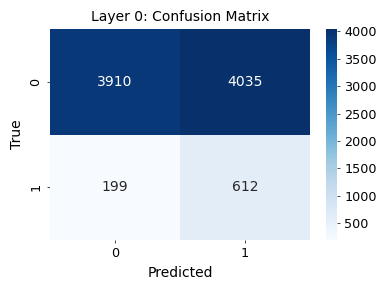


Layer 1:
Best C: 0.100
Train Balanced Accuracy: 0.785
Test Balanced Accuracy: 0.755
Train Weighted F1: 0.830
Test Weighted F1: 0.826
Class distribution:
Class False: 67870 samples
Class True: 6975 samples



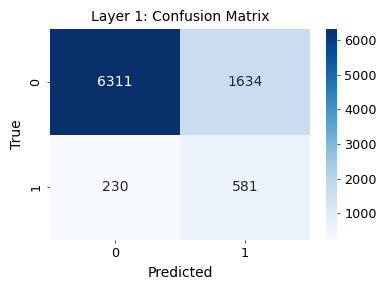


Layer 2:
Best C: 0.032
Train Balanced Accuracy: 0.931
Test Balanced Accuracy: 0.920
Train Weighted F1: 0.931
Test Weighted F1: 0.932
Class distribution:
Class False: 67870 samples
Class True: 6975 samples



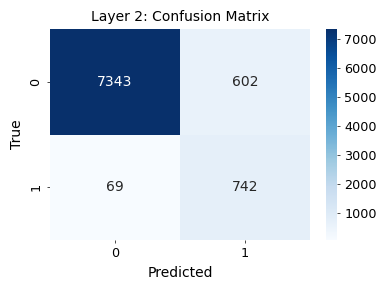


Layer 3:
Best C: 0.100
Train Balanced Accuracy: 0.978
Test Balanced Accuracy: 0.970
Train Weighted F1: 0.972
Test Weighted F1: 0.970
Class distribution:
Class False: 67870 samples
Class True: 6975 samples



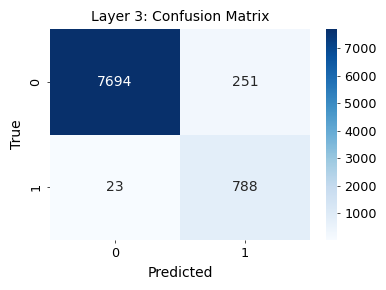

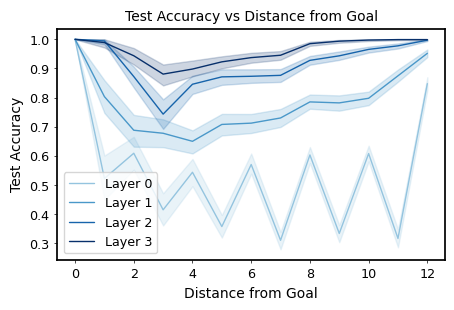

In [14]:
train_indices = []; test_indices = []
for i in range(len(Ys_dict['opt_action']["Y_train"])):
    opt_action = Ys_dict['opt_action']["Y_train"][i]
    state_feature = Ys_dict['state_feature']["Y_train"][i]
    next_state_feature = Ys_dict['next_state_feature']["Y_train"][i]
    train_indices.append(i)
for i in range(len(Ys_dict['opt_action']["Y_test"])):
    opt_action = Ys_dict['opt_action']["Y_test"][i]
    state_feature = Ys_dict['state_feature']["Y_test"][i]
    next_state_feature = Ys_dict['next_state_feature']["Y_test"][i]
    test_indices.append(i)
_Y_train = [Ys_dict['on_lr_path']["Y_train"][i] for i in train_indices]
_Y_test = [Ys_dict['on_lr_path']["Y_test"][i] for i in test_indices]
_X_train = [[X[i] for i in train_indices] for X in X_train] 
_X_test = [[X[i] for i in test_indices] for X in X_test]
pipeline, test_score = fit_and_evaluate_classification(
    _X_train, _Y_train, _X_test, _Y_test)

dist_from_goal = [Ys_dict['dist_from_goal']["Y_test"][i] for i in test_indices]
fig, ax = plt.subplots(figsize=(5,3))
colors = plt.colormaps['Blues'](np.linspace(0.4, 1, len(test_score)))
for l in range(len(test_score)):
    test_acc = test_score[l]
    sns.lineplot(x=dist_from_goal, y=test_acc, ax=ax, label=f'Layer {l}', color=colors[l])
ax.set_xlabel('Distance from Goal')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy vs Distance from Goal')
ax.legend()
plt.show()

Layer 0:
Best C: 0.001
Train Balanced Accuracy: 0.535
Test Balanced Accuracy: 0.490
Train Weighted F1: 0.534
Test Weighted F1: 0.490
Class distribution:
Class 1: 3324 samples
Class 2: 3174 samples



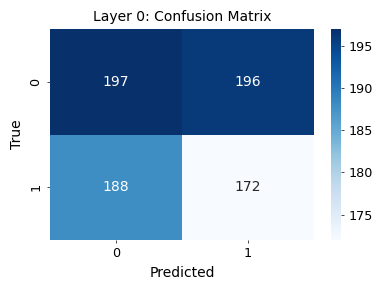


Layer 1:
Best C: 1.000
Train Balanced Accuracy: 0.749
Test Balanced Accuracy: 0.679
Train Weighted F1: 0.749
Test Weighted F1: 0.677
Class distribution:
Class 1: 3324 samples
Class 2: 3174 samples



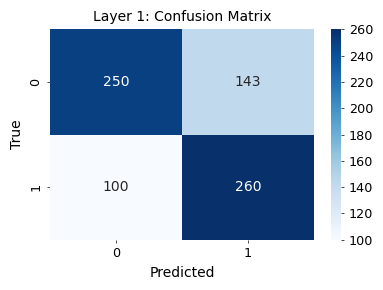


Layer 2:
Best C: 0.032
Train Balanced Accuracy: 0.767
Test Balanced Accuracy: 0.700
Train Weighted F1: 0.767
Test Weighted F1: 0.700
Class distribution:
Class 1: 3324 samples
Class 2: 3174 samples



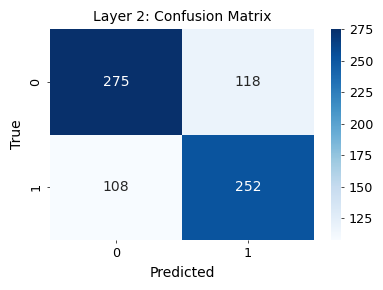


Layer 3:
Best C: 0.032
Train Balanced Accuracy: 0.977
Test Balanced Accuracy: 0.955
Train Weighted F1: 0.977
Test Weighted F1: 0.955
Class distribution:
Class 1: 3324 samples
Class 2: 3174 samples



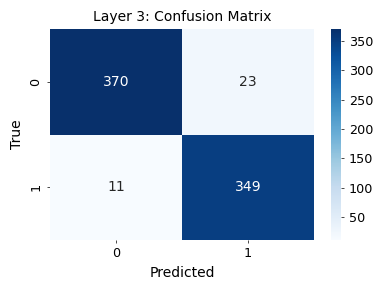

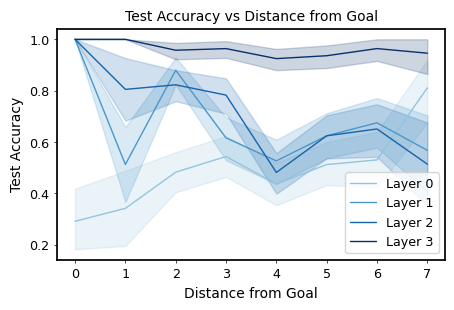

In [15]:
train_indices = []; test_indices = []
for i in range(len(Ys_dict['opt_action']["Y_train"])):
    opt_action = Ys_dict['opt_action']["Y_train"][i]
    state_feature = Ys_dict['state_feature']["Y_train"][i]
    next_state_feature = Ys_dict['next_state_feature']["Y_train"][i]
    if opt_action not in [1, 2]:
        continue
    if np.array_equal(state_feature, next_state_feature):
        continue
    train_indices.append(i)
for i in range(len(Ys_dict['opt_action']["Y_test"])):
    opt_action = Ys_dict['opt_action']["Y_test"][i]
    state_feature = Ys_dict['state_feature']["Y_test"][i]
    next_state_feature = Ys_dict['next_state_feature']["Y_test"][i]
    if opt_action not in [1, 2]:
        continue
    if np.array_equal(state_feature, next_state_feature):
        continue
    test_indices.append(i)
_Y_train = [Ys_dict['opt_action']["Y_train"][i] for i in train_indices]
_Y_test = [Ys_dict['opt_action']["Y_test"][i] for i in test_indices]
_X_train = [[X[i] for i in train_indices] for X in X_train] 
_X_test = [[X[i] for i in test_indices] for X in X_test]
pipeline, test_score = fit_and_evaluate_classification(
    _X_train, _Y_train, _X_test, _Y_test)

dist_from_goal = [Ys_dict['dist_from_goal']["Y_test"][i] for i in test_indices]
fig, ax = plt.subplots(figsize=(5,3))
colors = plt.colormaps['Blues'](np.linspace(0.4, 1, len(test_score)))
for l in range(len(test_score)):
    test_acc = test_score[l]
    sns.lineplot(x=dist_from_goal, y=test_acc, ax=ax, label=f'Layer {l}', color=colors[l])
ax.set_xlabel('Distance from Goal')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy vs Distance from Goal')
ax.legend()
plt.show()

Layer 0:
Best C: 0.001
Train Balanced Accuracy: 0.209
Test Balanced Accuracy: 0.204
Train Weighted F1: 0.093
Test Weighted F1: 0.088
Class distribution:
Class 0: 957 samples
Class 1: 1504 samples
Class 2: 2250 samples
Class 3: 2750 samples
Class 4: 4020 samples
Class 5: 4782 samples
Class 6: 6548 samples
Class 7: 6735 samples
Class 8: 8849 samples
Class 9: 8596 samples
Class 10: 10654 samples
Class 11: 8577 samples
Class 12: 8623 samples



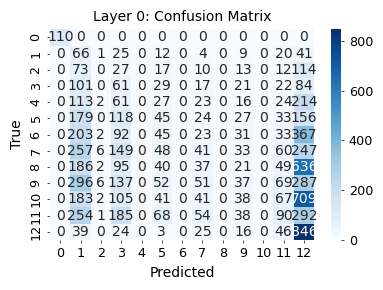


Layer 1:
Best C: 0.010
Train Balanced Accuracy: 0.342
Test Balanced Accuracy: 0.307
Train Weighted F1: 0.225
Test Weighted F1: 0.192
Class distribution:
Class 0: 957 samples
Class 1: 1504 samples
Class 2: 2250 samples
Class 3: 2750 samples
Class 4: 4020 samples
Class 5: 4782 samples
Class 6: 6548 samples
Class 7: 6735 samples
Class 8: 8849 samples
Class 9: 8596 samples
Class 10: 10654 samples
Class 11: 8577 samples
Class 12: 8623 samples



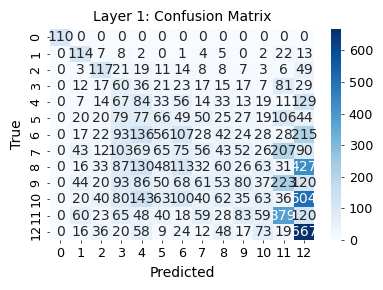


Layer 2:
Best C: 0.316
Train Balanced Accuracy: 0.484
Test Balanced Accuracy: 0.417
Train Weighted F1: 0.366
Test Weighted F1: 0.303
Class distribution:
Class 0: 957 samples
Class 1: 1504 samples
Class 2: 2250 samples
Class 3: 2750 samples
Class 4: 4020 samples
Class 5: 4782 samples
Class 6: 6548 samples
Class 7: 6735 samples
Class 8: 8849 samples
Class 9: 8596 samples
Class 10: 10654 samples
Class 11: 8577 samples
Class 12: 8623 samples



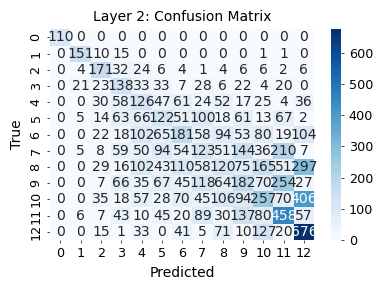


Layer 3:
Best C: 0.316
Train Balanced Accuracy: 0.514
Test Balanced Accuracy: 0.453
Train Weighted F1: 0.395
Test Weighted F1: 0.337
Class distribution:
Class 0: 957 samples
Class 1: 1504 samples
Class 2: 2250 samples
Class 3: 2750 samples
Class 4: 4020 samples
Class 5: 4782 samples
Class 6: 6548 samples
Class 7: 6735 samples
Class 8: 8849 samples
Class 9: 8596 samples
Class 10: 10654 samples
Class 11: 8577 samples
Class 12: 8623 samples



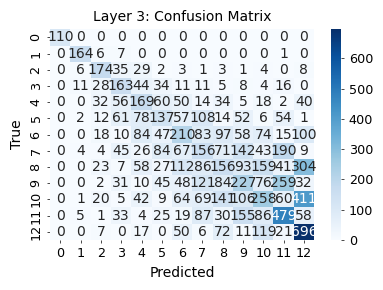

In [16]:
pipeline, test_score = fit_and_evaluate_classification(
    X_train,
    Ys_dict["dist_from_goal"]["Y_train"],
    X_test,
    Ys_dict["dist_from_goal"]["Y_test"]
    )